In [67]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


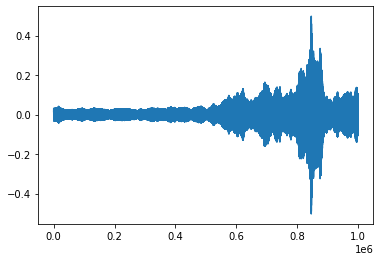

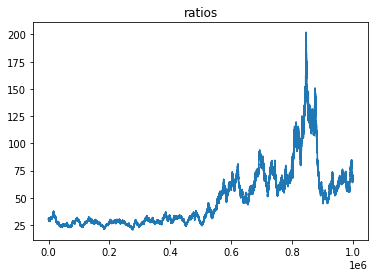

In [213]:
from constant_product_amm import Simulator

sim = Simulator()
sim.run(num=1000000)

plt.plot(sim.deltas)
plt.show()

# plt.hist(sim.sizes)
# plt.show()
#
# plt.title("a/b swaps in")
# plt.plot(sim.a_swaps)
##plt.plot(sim.b_swaps)
# plt.show()
#
# plt.hist(sim.a_swaps)
# plt.show()
#
# plt.hist(sim.b_swaps)
# plt.show()
#
# plt.title("swap sizes")
# plt.plot(sim.swaps)
# plt.show()

# plt.title("a supply")
# plt.plot(sim.a_supply)
# plt.show()
# plt.title("b supply")
# plt.plot(sim.b_supply)
# plt.show()

plt.title("ratios")
plt.plot(sim.ratios)
plt.show()